In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/elomia

Mounted at /content/drive
/content/drive/MyDrive/elomia


# TPU configuration

In [ ]:
# import tensorflow as tf
# import os

# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

# assert float('.'.join(tf.__version__.split('.')[:2])) >= 1.14, 'Make sure that Tensorflow version is at least 1.14'

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

# strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 4.0 MB 8.4 MB/s 
     |████████████████████████████████| 77 kB 8.3 MB/s 
     |████████████████████████████████| 596 kB 73.8 MB/s 
     |████████████████████████████████| 6.6 MB 81.9 MB/s 
     |████████████████████████████████| 895 kB 67.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 8.8 MB/s 
     |████████████████████████████████| 1.1 MB 61.3 MB/s 
     |████████████████████████████████| 136 kB 96.9 MB/s 
     |████████████████████████████████| 212 kB 90.9 MB/s 
     |████████████████████████████████| 127 kB 72.2 MB/s 
     |████████████████████████████████| 271 kB 86.8 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
     |████████████████████████████████| 144 kB 95.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib

In [ ]:
import pandas as pd

pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

emd_df = pd.read_csv("API/ParlAI_ex/emp_data_train.csv", on_bad_lines='skip')
emd_df['utterance'] = emd_df['utterance'].str.lower()
emd_df['prompt'] = emd_df['prompt'].str.lower()

emd_df.reset_index(inplace=True)

In [ ]:
import numpy as np

# slice_most_repeated_indexes = emd_df['speaker_idx'].value_counts()[0:20].index

# most_repeated = emd_df[emd_df['speaker_idx'].isin(slice_most_repeated_indexes)]

most_repeated[["utterance", "context"]].head()

# !!!!! 
most_repeated = most_repeated[((most_repeated["context"] == "joyful") | 
                               (most_repeated["context"] == "angry") |
                               (most_repeated["context"] == "excited") |
                               (most_repeated["context"] == "sad") |
                               (most_repeated["context"] == "annoyed") |
                               (most_repeated["context"] == "afraid") |
                               (most_repeated["context"] == "lonely")
                               )]

# !!!!! 

unq_contexts = most_repeated["context"].unique().tolist()
print(len(unq_contexts))

most_repeated["context_label"] = list(map(lambda x: unq_contexts.index(x), most_repeated["context"]))
# most_repeated["two_input"] = most_repeated[['utterance', 'prompt']].apply(lambda x: ' '.join(x), axis=1)

# unq_speakers = most_repeated["speaker_idx"].unique().tolist()
# print(len(unq_speakers))
# most_repeated["speaker_label"] = list(map(lambda x: unq_speakers.index(x), most_repeated["speaker_idx"]))



7


In [ ]:
most_repeated["context"].value_counts(ascending=False)#.unique()

angry      1162
excited    1109
sad        1043
annoyed    1018
afraid      977
lonely      975
joyful      913
Name: context, dtype: int64

In [ ]:
str_lengths = list(map(lambda x: len(str(x)), most_repeated["utterance"]))
print(len(str_lengths))

7197


6531


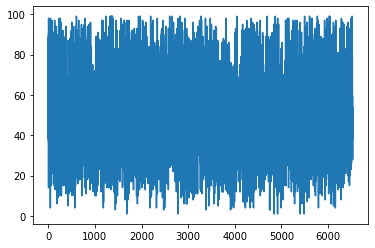

In [ ]:
import matplotlib.pyplot as plt
import random # to speed up visualization


vis_str_lengths = list(filter(lambda x: x < 100, str_lengths))
print(len(vis_str_lengths))
plt.plot(vis_str_lengths)

In [ ]:
model_name = "bert-base-cased"

In [ ]:
from datasets import Dataset
from transformers import DefaultDataCollator
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from transformers import AutoTokenizer

max_length = 100 

tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=max_length)

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(most_repeated["utterance"],
                                                          most_repeated["context_label"], 
                                                          test_size=0.2)


# y_train_cont = to_categorical(y_train_s)
# # y_train_speaker = to_categorical(y_train_s["speaker_label"])

# y_val_cont = to_categorical(y_val_s)
# # y_val_speaker = to_categorical(y_val_s["speaker_label"])

train_df = pd.DataFrame([X_train_s, y_train_s]).transpose()
val_df = pd.DataFrame([X_val_s, y_val_s]).transpose()

def tokenize_function(examples):
    return tokenizer(examples["utterance"], padding="max_length", truncation=True)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="context_label",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)


tf_val_dataset = tokenized_val_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="context_label",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
X_train_s.tolist()

['that sucks_comma_ how old was the goldfish?',
 "that's good. were you nervous at first?",
 "i'm feeling very happy right now.",
 'oh my_comma_ i hate when that happens. it makes me so angry.',
 'they never pay for anything and always look to me when the bill comes.',
 'mine is july 1st. did you have a party for them?',
 'yeah i have experience a lot of that recently',
 'she is amazing for him.  i am so happy!',
 'i cried all day when my grandma died.',
 'i was a lonesome weekend. all of my friends were busy',
 'why is it a great day?',
 'it is just the fact i can not see.',
 'i went to the town hall to renew driving license. the agent gave wrong information. because of him_comma_ i wasted three months.',
 'she asked for some butter',
 'i was happy when i woke up and it was friday!',
 'i am so irritated it took so long.',
 'we got a new printer installed at work today',
 "i can't wait for the new soccer season to start",
 'we are going back home to louisiana to see friends and family'

In [ ]:
from transformers import TFBertModel

#with strategy.scope():

bert = TFBertModel.from_pretrained(model_name)

print(len(bert.bert.encoder.layer))

for i in range(len(bert.bert.encoder.layer)):
    bert.bert.encoder.layer[i].trainable = i >= 10

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


12


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

import tensorflow as tf


In [ ]:
# with strategy.scope():
max_len = 512
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)

out = Dense(128, activation='relu')(out)
out = Dense(32, activation = 'relu')(out)

y1 = Dense(7, activation = 'softmax', name="context")(out)  
# y2 = Dense(20, activation = 'softmax', name="speaker")(out) 


model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y1) #[y1, y2])
model.layers[2].trainable = True

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam


# # with strategy.scope():
optimizer = Adam(learning_rate=5e-05, #e--5
                  decay=0.01,
                  clipnorm=1.0)

loss = SparseCategoricalCrossentropy(from_logits = True)
metric = SparseCategoricalAccuracy('balanced_accuracy')
model.compile(optimizer = optimizer, loss = loss, metrics = metric)
# model.run_eagerly = True

In [1]:
import os
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# tf.compat.v1.enable_eager_execution()

exp_path = './API/ParlAI_ex/bert_logs/exps'

tensoboard_callback = TensorBoard(log_dir=exp_path)
checkpoint_callback = ModelCheckpoint(os.path.join(exp_path,"checkpoints"),
                                      monitor='val_loss', 
                                      verbose=1,
                                      mode='min',
                                      save_weights_only=False,
                                      save_best_only=True)



# with strategy.scope():

train_history = model.fit(tf_train_dataset,
                          validation_data=tf_val_dataset,
                          # callbacks=[tensoboard_callback, checkpoint_callback],
                          epochs=150,
                          batch_size=20,
                          shuffle=True)

NameError: ignored

In [ ]:
x_val

In [ ]:
model.load_weights("/content/drive/MyDrive/elomia/API/ParlAI_ex/bert_logs/utter_context/checkpoints")

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/12/multiclass-classification-using-transformers/

In [ ]:
predicted_raw = [model.predict({'input_ids':example['input_ids'],'attention_mask':example['attention_mask']}) for example, label in tf_val_dataset]

[array([[9.6414733e-04, 7.5807720e-01, 2.1313302e-02, 2.0477392e-01,
         6.3125039e-03, 3.1248953e-03, 5.4340172e-03],
        [2.7351140e-03, 2.4897166e-02, 6.6028371e-02, 9.3537057e-03,
         8.0709803e-01, 4.0837699e-03, 8.5803859e-02],
        [4.3790047e-03, 1.9862933e-02, 2.2782749e-01, 9.3840715e-03,
         6.9076449e-01, 5.0390693e-03, 4.2742968e-02],
        [1.9228290e-03, 6.4872795e-05, 3.1906186e-04, 8.5616502e-04,
         3.1946437e-04, 9.9649042e-01, 2.7222532e-05],
        [2.6035884e-03, 8.4401443e-05, 3.4467410e-04, 5.5495457e-04,
         1.9868674e-04, 9.9620467e-01, 9.0482163e-06],
        [2.0505041e-03, 9.1553611e-01, 9.3506631e-03, 5.6406453e-02,
         8.5457722e-03, 6.7179534e-03, 1.3924909e-03],
        [1.3535021e-02, 2.1277891e-01, 5.0924140e-01, 1.8153618e-01,
         6.4583078e-02, 7.7790720e-03, 1.0546340e-02],
        [5.4806443e-03, 5.4825276e-02, 7.1811235e-01, 1.0365398e-02,
         1.9213741e-01, 9.0419380e-03, 1.0036993e-02]], dtype=f

In [ ]:
predicted_raw

[array([[9.6414733e-04, 7.5807720e-01, 2.1313302e-02, 2.0477392e-01,
         6.3125039e-03, 3.1248953e-03, 5.4340172e-03],
        [2.7351140e-03, 2.4897166e-02, 6.6028371e-02, 9.3537057e-03,
         8.0709803e-01, 4.0837699e-03, 8.5803859e-02],
        [4.3790047e-03, 1.9862933e-02, 2.2782749e-01, 9.3840715e-03,
         6.9076449e-01, 5.0390693e-03, 4.2742968e-02],
        [1.9228290e-03, 6.4872795e-05, 3.1906186e-04, 8.5616502e-04,
         3.1946437e-04, 9.9649042e-01, 2.7222532e-05],
        [2.6035884e-03, 8.4401443e-05, 3.4467410e-04, 5.5495457e-04,
         1.9868674e-04, 9.9620467e-01, 9.0482163e-06],
        [2.0505041e-03, 9.1553611e-01, 9.3506631e-03, 5.6406453e-02,
         8.5457722e-03, 6.7179534e-03, 1.3924909e-03],
        [1.3535021e-02, 2.1277891e-01, 5.0924140e-01, 1.8153618e-01,
         6.4583078e-02, 7.7790720e-03, 1.0546340e-02],
        [5.4806443e-03, 5.4825276e-02, 7.1811235e-01, 1.0365398e-02,
         1.9213741e-01, 9.0419380e-03, 1.0036993e-02]], dtype=f

In [ ]:
exs = [label for example, label in tf_val_dataset]
print(len(exs))

180


In [ ]:
y_predicted = np.argmax(item_preds, axis = 1)
y_true = np.argmax(y_val_cont, axis = 1) #[y_val_cont, y_val_speaker]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predicted))

ValueError: ignored

In [ ]:
test = tokenizer.encode("I like you",
                         truncation=False,
                         padding="max_length",
                         return_tensors="tf")

 
model.predict(test)

ValueError: ignored

In [ ]:
test

<tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[ 101, 1045, 2066, 2017,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [ ]:

    # epochs = 2
    # for epoch in range(epochs):
    #     print("\nStart of epoch %d" % (epoch,))

    #     for step, (x_batch_train, y_batch_train) in enumerate(zip({'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']}, [y_train_cont, y_train_speaker])):

    #         # Open a GradientTape to record the operations run
    #         # during the forward pass, which enables auto-differentiation.
    #         with tf.GradientTape() as tape:

    #             # Run the forward pass of the layer.
    #             # The operations that the layer applies
    #             # to its inputs are going to be recorded
    #             # on the GradientTape.
    #             print(x_batch_train)
    #             logits = model(x_batch_train, training=True)  # Logits for this minibatch

    #             # Compute the loss value for this minibatch.
    #             loss_value = loss_fn(y_batch_train, logits)

    #         # Use the gradient tape to automatically retrieve
    #         # the gradients of the trainable variables with respect to the loss.
    #         grads = tape.gradient(loss_value, model.trainable_weights)

    #         # Run one step of gradient descent by updating
    #         # the value of the variables to minimize the loss.
    #         optimizer.apply_gradients(zip(grads, model.trainable_weights))

    #         # Log every 200 batches.
    #         if step % 200 == 0:
    #             print(
    #                 "Training loss (for one batch) at step %d: %.4f"
2    #             )
    #             print("Seen so far: %s samples" % ((step + 1) * batch_size))

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()

for epoch in range(1):

    for ind, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        loss = outputs.loss
        if ind%300==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        optimizer.zero_grad()

        progress_bar.update(1)

In [ ]:


def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_dataloader, 0):
            data = {k: v.to(device) for k, v in data.items()}
            outputs = model(**data)

            targets = data['labels'].to(device, dtype = torch.float)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs.logits).cpu().detach().numpy().tolist())
            break
    return fin_outputs, fin_targets



In [ ]:


for epoch in range(1):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

